# Test du modèle déployé sur Azure Machine Learning

On va appeler le service web qui utilise le modèle que l'on a déployé.

On cela on va prendre un échantillon de tweets du jeu de données et tester le bon fonctionnement du Web Service, et regarder les métriques obtenues.

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import urllib.request
import json

import pandas as pd

import src.helpers.data_helpers as dth

# Charger les variables d'environnement depuis le ficher .env
from dotenv import load_dotenv

load_dotenv()
url = os.getenv("AZURE_API_CUSTOM_MODEL_ENDPOINT")
api_key = os.getenv("AZURE_API_CUSTOM_MODEL_KEY")

# Nombre de tweets pour le test
SAMPLE_SIZE = 2000

### Chargement du jeu de données

In [7]:
# Charger les données depuis le fichier csv
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', sep=',', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Ne garder que les colonnes nécessaires
data = data[["text", "target"]]

# On supprime les tweets en doublons
data.drop_duplicates(subset=['text'], inplace=True)

# Remplacer les valeurs par les vrais labels
data['target'] = data['target'].map(
    {
        0: "NEGATIF",
        4: "POSITIF"
    }
)

# Binarize target
data['target'] = data['target'].map(
    {
        "NEGATIF": 0,
        "POSITIF": 1,
    }
)

# Echantilloner le jeu de données
data_sample = pd.concat([data[data["target"] == 0].sample(n = int(SAMPLE_SIZE/2)), data[data["target"] == 1].sample(n = int(SAMPLE_SIZE/2))], axis=0)

data_sample.describe()

,target
count,2000.000000
mean,0.500000
std,0.500125
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


On récupère 2000 tweets aléatoirement depuis le jeu de données que l'on va utiliser dans l'appel API.

In [29]:
X = data_sample['text'].tolist()
y = data_sample['target'].tolist()

### Préparation de la requête

In [26]:
data =  {
  "data": X
}

### Appel API

In [27]:
body = str.encode(json.dumps(data))

# The azureml-model-deployment header will force the request to go to a specific deployment.
# Remove this header to have the request observe the endpoint traffic rules
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))


b'[[[0.6976175904273987], [0.236867755651474], [0.907488226890564], [0.06694918125867844], [0.3372633755207062], [0.007911310531198978], [0.02921834960579872], [0.6755477786064148], [0.5217393040657043], [0.09833257645368576], [0.10733454674482346], [0.08420019596815109], [0.03228136897087097], [0.047242436558008194], [0.07078103721141815], [0.5512888431549072], [0.5387535095214844], [0.27074864506721497], [0.08066157251596451], [0.8263376951217651], [0.22571276128292084], [0.695126473903656], [0.016572749242186546], [0.04851222038269043], [0.05249050632119179], [0.03291316330432892], [0.10585525631904602], [0.13327981531620026], [0.04179004207253456], [0.09878716617822647], [0.12576881051063538], [0.2353198081254959], [0.0013765895273536444], [0.8024070262908936], [0.059756696224212646], [0.3262684941291809], [0.010670380666851997], [0.03428797796368599], [0.9037048816680908], [0.7221739888191223], [0.0065014357678592205], [0.4586881697177887], [0.043632347136735916], [0.6595656275749

In [30]:
result_list = json.loads(result.decode('utf-8'))

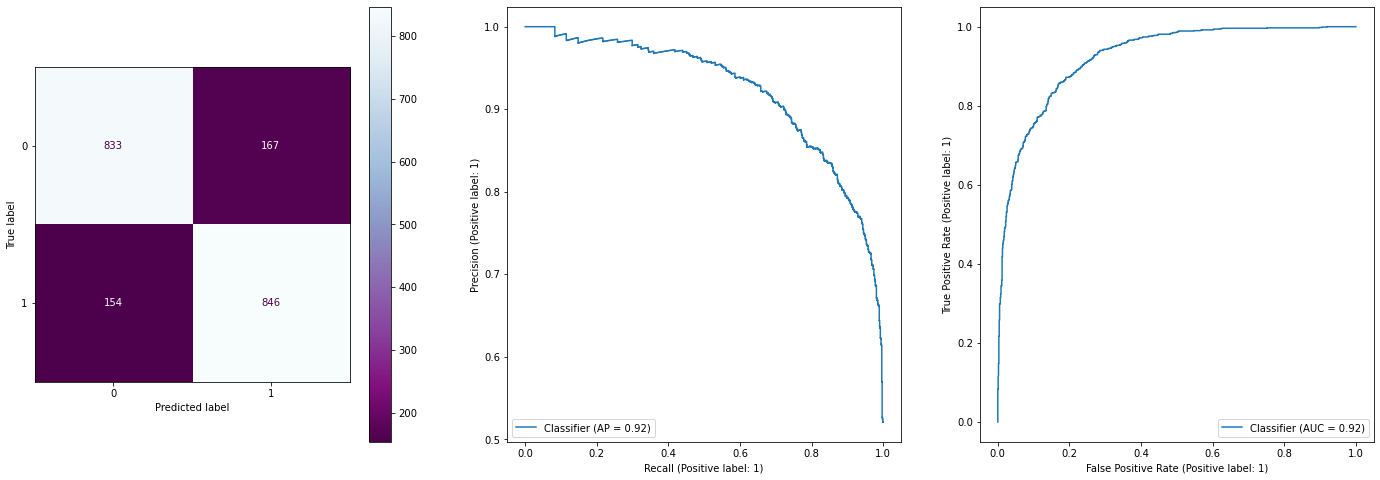

In [31]:
dth.plot_classifier_results(None, None, y, result_list[1], result_list[0])

On obtient quasiment les mêmes résultats en testant le modèle déployé sur un échantillon de 2000 tweets.